In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import heapq
from heapq import heappush, heappop
from matplotlib import animation

In [2]:
N=20
array = np.zeros((N,N))

# 0 -> empty
# 1 -> wall
# 2 -> shelf
# 3 -> entrance
# 4 -> cashier
# 5 -> item
# 6 -> path

#make a discrete colormap for each of the 6 classes
cmap = colors.ListedColormap(['white','black','grey','green','blue', 'red','orange'])
norm = colors.BoundaryNorm(np.arange(0,8,1), cmap.N)

#walls
array[0,:] = 1
array[-1,:] = 1
array[:,0] = 1
array[:,-1] = 1
walls = [tuple(x) for x in np.argwhere(array == 1)]

#entrance
array[-1,9:11] = 3
entrances = [tuple(x) for x in np.argwhere(array == 3)]

#horizontal shelves
array[1,4:16] = 2
array[4,4:16] = 2
array[5,4:16] = 2
#vertical shelves
array[9:14,4] = 2
array[9:14,5] = 2
array[9:14,9] = 2
array[9:14,10] = 2
array[9:14,15] = 2
array[9:14,14] = 2
shelves = [tuple(x) for x in np.argwhere(array == 2)]

#cashier
array[16,7] = 4
array[16,12] = 4
cashiers = [tuple(x) for x in np.argwhere(array == 4)]

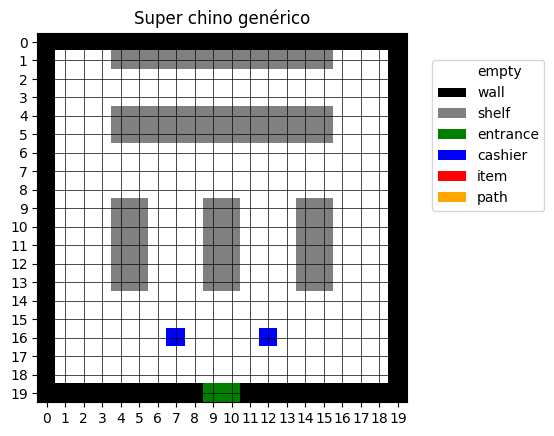

In [3]:
plt.imshow(array, cmap=cmap, norm=norm, interpolation='nearest')
plt.xticks(np.arange(0,N,1))
plt.yticks(np.arange(0,N,1))
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=.5)
plt.title('Super chino genérico')
#legend with each color and its meaning
plt.legend(handles=[plt.Rectangle((0,0),1,1,fc=cmap(0)),
                    plt.Rectangle((0,0),1,1,fc=cmap(1)),
                    plt.Rectangle((0,0),1,1,fc=cmap(2)),
                    plt.Rectangle((0,0),1,1,fc=cmap(3)),
                    plt.Rectangle((0,0),1,1,fc=cmap(4)),
                    plt.Rectangle((0,0),1,1,fc=cmap(5)),
                    plt.Rectangle((0,0),1,1,fc=cmap(6))],
              labels=['empty','wall','shelf','entrance','cashier','item','path'],
                loc='lower left', bbox_to_anchor=(1.05, .5))


plt.show()

In [4]:
def heuristic(node, goal):
    '''
    Heuristic function for A* algorithm.
    '''
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

def a_star(grid, start, end):
    '''
    Uses A* algorithm to find the shortest path between start and end, on the grid.
    '''
    rows, cols = len(grid), len(grid[0])
    closed_set = set()
    open_set = set([start])
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic(start, end)}

    while open_set:
        current = min(open_set, key=f_score.get)
        if current == end:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return list(reversed(path))

        open_set.remove(current)
        closed_set.add(current)

        neighbors = [(current[0] - 1, current[1]), 
                     (current[0] + 1, current[1]), 
                     (current[0], current[1] - 1), 
                     (current[0], current[1] + 1)]

        for neighbor in neighbors:
            if neighbor[0] < 0 or neighbor[0] >= rows or neighbor[1] < 0 or neighbor[1] >= cols:
                continue

            if grid[neighbor[0]][neighbor[1]] == 1:
                continue

            if grid[neighbor[0]][neighbor[1]] == 2 and neighbor != end:
                continue

            tentative_g_score = g_score[current] + grid[neighbor[0]][neighbor[1]]
            if neighbor in closed_set and tentative_g_score >= g_score.get(neighbor, float('inf')):
                continue

            if tentative_g_score < g_score.get(neighbor, float('inf')):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, end)
                if neighbor not in open_set:
                    open_set.add(neighbor)

    return []

def next_point_a_star(grid, start, points):
    '''
    Finds the closest point to start in points, using A* algorithm.
    '''
    min_dist = float('inf')
    min_path = None
    closest_point = None
    for point in points:
        path = a_star(grid, start, point)
        if len(path) < min_dist:
            min_dist = len(path)
            closest_point = point
            min_path = path
    return closest_point, min_path


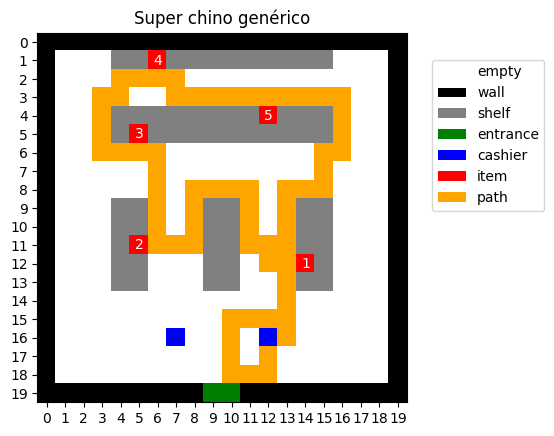

In [5]:
copy_array = array.copy()
items = [(11,5), (5,5), (4,12), (1,6), (12,14)] #example

items_left=items.copy()
ordered_items = []
path = [tuple(entrances[1])] #start at the entrance

while len(items_left) > 0:
    next_item, next_path = next_point_a_star(copy_array, path[-1], items_left)
    path += next_path
    items_left.remove(next_item)
    ordered_items.append(next_item)

#find the closest cashier to the last item
cashier, cashier_path = next_point_a_star(copy_array, path[-1], cashiers)
path += cashier_path
#find the closest entrance to the cashier
entrance, entrance_path = next_point_a_star(copy_array, path[-1], entrances)
path += entrance_path
    
#add the path to the array
for point in path:
    copy_array[point[0], point[1]] = 6

#rewrite the array with the items and cashiers (over the path)
for item in items:
    copy_array[item[0], item[1]] = 5
for cashier in cashiers:
    copy_array[cashier[0], cashier[1]] = 4
for entrance in entrances:
    copy_array[entrance[0], entrance[1]] = 3

#write the order of the items as text on top of the corresponding item
for i, item in enumerate(ordered_items):
    plt.text(item[1], item[0], i+1, color='w', ha='center', va='center')  


plt.imshow(copy_array, cmap=cmap, norm=norm, interpolation='nearest')
plt.xticks(np.arange(0,N,1))
plt.yticks(np.arange(0,N,1))
plt.title('Super chino genérico')
plt.legend(handles=[plt.Rectangle((0,0),1,1,fc=cmap(0)),
                    plt.Rectangle((0,0),1,1,fc=cmap(1)),
                    plt.Rectangle((0,0),1,1,fc=cmap(2)),
                    plt.Rectangle((0,0),1,1,fc=cmap(3)),
                    plt.Rectangle((0,0),1,1,fc=cmap(4)),
                    plt.Rectangle((0,0),1,1,fc=cmap(5)),
                    plt.Rectangle((0,0),1,1,fc=cmap(6))],
                labels=['empty','wall','shelf','entrance','cashier','item','path'],
                loc='lower left', bbox_to_anchor=(1.05, .5))

plt.show()
